# Histopathologic Cancer Detection: Exploratory Data Analysis.
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from time import time
from tqdm import tqdm_notebook

from keras.layers import Input, Dense, Flatten, Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

from data.data import load_data
from generators.augment import augmentor, show_augmentations

from skimage import exposure
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
ONLY_USE_SUBSET = True # Set to true when running locally
DIMENSIONS = (96, 96)

## Importing dataset
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [3]:
(x_train, y_train, meta_train), (x_valid, y_valid, meta_valid),_ = load_data() 

## Exploratory Data Analysis

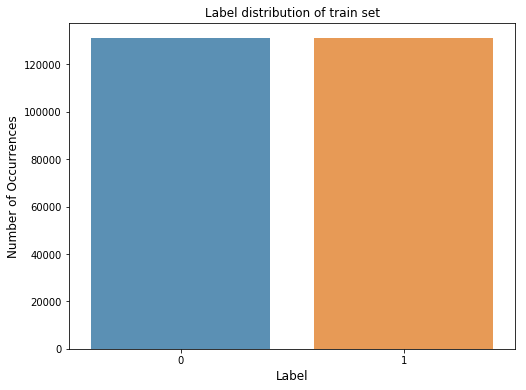

In [4]:
unique_values, unique_counts = np.unique(np.ravel(y_train), return_counts=True)
plt.figure(figsize=(8,6))
sns.barplot(unique_values, unique_counts, alpha=0.8)
plt.title('Label distribution of train set')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.show()

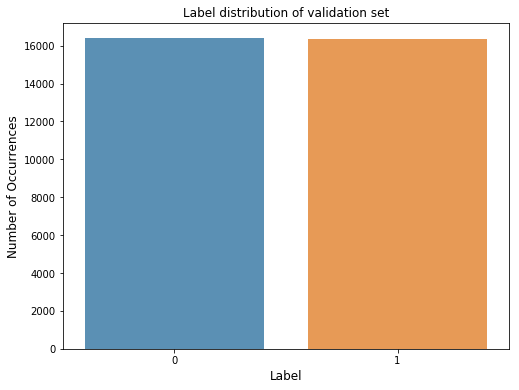

In [7]:
unique_values, unique_counts = np.unique(np.ravel(y_valid), return_counts=True)
plt.figure(figsize=(8,6))
sns.barplot(unique_values, unique_counts, alpha=0.8)
plt.title('Label distribution of validation set')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.show()

Here, we visualize some data from the training set, and the corresponding label.

<class 'numpy.ndarray'>
(262144, 96, 96, 3)
x train is  <class 'keras.utils.io_utils.HDF5Matrix'>
[[[226 209 225]
  [224 210 225]
  [223 211 223]
  ...
  [218 178 230]
  [214 182 221]
  [188 161 192]]

 [[223 209 224]
  [222 210 224]
  [221 211 222]
  ...
  [127  87 150]
  [159 126 181]
  [204 176 225]]

 [[222 210 224]
  [221 210 224]
  [219 211 222]
  ...
  [ 77  38 117]
  [ 42   8  84]
  [137 107 179]]

 ...

 [[123  81 165]
  [128  90 173]
  [126  91 173]
  ...
  [203 135 210]
  [226 155 223]
  [202 130 194]]

 [[ 90  52 139]
  [ 90  56 142]
  [ 79  45 131]
  ...
  [216 152 230]
  [179 113 185]
  [217 152 220]]

 [[ 85  51 138]
  [101  68 155]
  [ 91  59 144]
  ...
  [200 136 220]
  [204 142 217]
  [192 130 203]]]


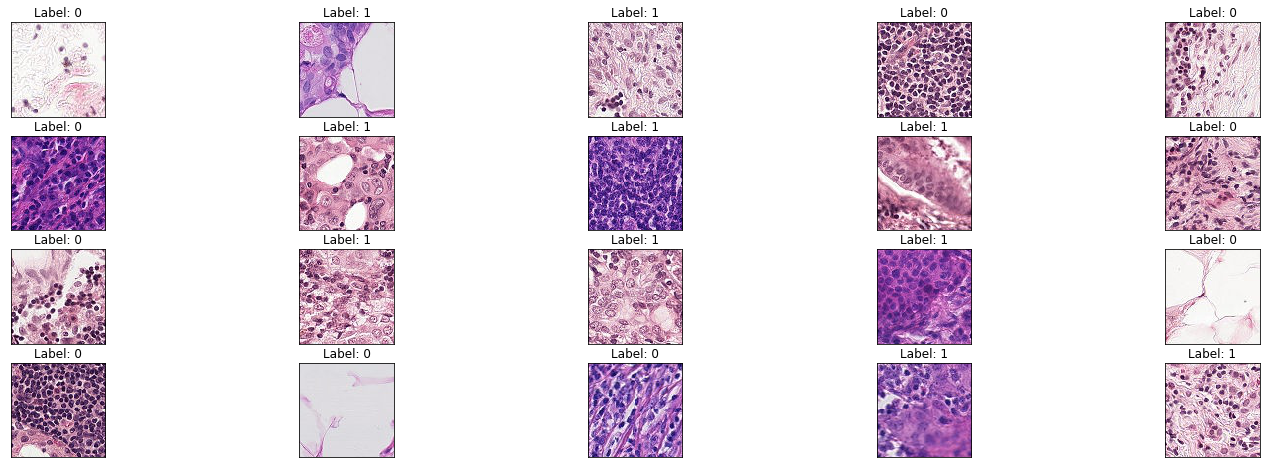

In [61]:

fig = plt.figure(figsize=(25, 8))
# display 20 images
x = x_train[0]
print(type(x))
print(x_train.shape)
print("x train is ", type(x_train))

idx = np.random.choice(len(x_train), 20)

z = x_train[np.sort(idx)]

for pos, (im, label) in enumerate(zip(x_train[np.sort(idx)], y_train[np.sort(idx)])):
    ax = fig.add_subplot(4, 10//2, pos+1, xticks=[], yticks=[])
    plt.imshow(im)
    label =  np.ravel(label)[0]
    ax.set_title('Label: {}'.format(label))
 

Below, we create ImageDataGenerators for the train, validation, and test set. 
Augmentations can be specified below. For more information about augmentations, please inspect the [Keras documentation](https://keras.io/preprocessing/image/)

### Examples of Data augmentation
Here we show some examples of data augmentation on the dataset. For simplicity, a single image is drawn (fixed), so that the possible augmentations are more visible and comparable

[[[0.8862746  0.8196079  0.882353  ]
  [0.87843144 0.8235295  0.882353  ]
  [0.8745099  0.82745105 0.8745099 ]
  ...
  [0.854902   0.69803923 0.90196085]
  [0.83921576 0.7137255  0.86666673]
  [0.7372549  0.6313726  0.75294125]]

 [[0.8745099  0.8196079  0.87843144]
  [0.8705883  0.8235295  0.87843144]
  [0.86666673 0.82745105 0.8705883 ]
  ...
  [0.49803925 0.34117648 0.5882353 ]
  [0.62352943 0.49411768 0.70980394]
  [0.8000001  0.6901961  0.882353  ]]

 [[0.8705883  0.8235295  0.87843144]
  [0.86666673 0.8235295  0.87843144]
  [0.8588236  0.82745105 0.8705883 ]
  ...
  [0.3019608  0.14901961 0.45882356]
  [0.16470589 0.03137255 0.32941177]
  [0.5372549  0.41960788 0.7019608 ]]

 ...

 [[0.48235297 0.31764707 0.64705884]
  [0.5019608  0.3529412  0.6784314 ]
  [0.49411768 0.35686275 0.6784314 ]
  ...
  [0.7960785  0.5294118  0.8235295 ]
  [0.8862746  0.60784316 0.8745099 ]
  [0.79215693 0.50980395 0.7607844 ]]

 [[0.3529412  0.20392159 0.54509807]
  [0.3529412  0.21960786 0.5568628 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


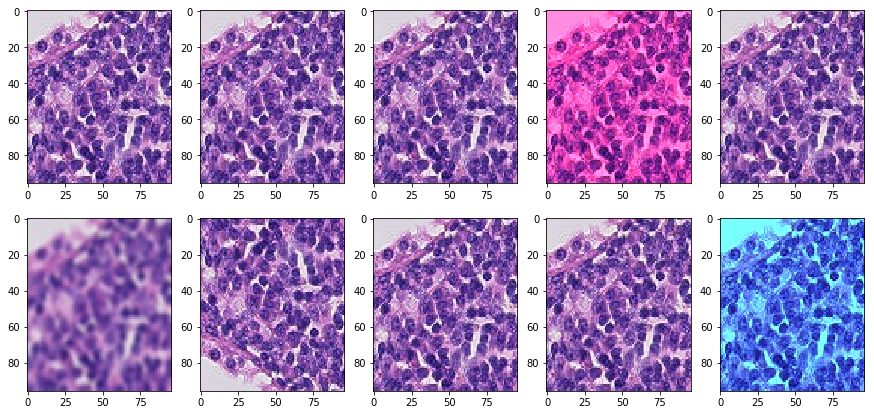

In [10]:
# define a generator with the augmentor
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        preprocessing_function = augmentor
    )
    
batches = show_augmentations(train_datagen, x_train, y_train)

# below shows the problem as a matrix. In case you want the images to show, add rescale = 1./255 to the train_datagen options
# The problem is that the RBG values are above 255 in some cases, for no apparant reason. I think this is due to the Multiply imgaug which can multiple a number in a specific channels above the 255 regular threshold.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([ 0,  0,  0, ..., 95, 95, 95]), array([ 0,  1,  2, ..., 93, 94, 95]), array([0, 0, 0, ..., 0, 0, 0]))
The wrong batch with strange values is: [[1.2990001  0.54701877 0.8964062 ]
 [1.2875047  0.549636   0.8964062 ]
 [1.2817568  0.55225337 0.8884381 ]
 [1.2645135  0.557488   0.88047004]
 [1.2587657  0.5601053  0.88047004]
 [1.2472701  0.5627226  0.876486  ]
 [1.2472701  0.5627226  0.876486  ]
 [1.2587657  0.5601053  0.88047004]
 [1.2702613  0.5601053  0.884454  ]
 [1.2817568  0.55225337 0.8884381 ]
 [1.2875047  0.549636   0.8884381 ]
 [1.2817568  0.54701877 0.884454  ]
 [1.2817568  0.54701877 0.884454  ]
 [1.2817568  0.55225337 0.8884381 ]
 [1.2760091  0.5548707  0.8884381 ]
 [1.2817568  0.557488   0.89242214]
 [1.2587657  0.557488   0.8485978 ]
 [1.2530179  0.5548707  0.8605499 ]
 [1.2472701  0.549636   0.86851794]
 [1.2472701  0.55225337 0.8884381 ]
 [1.2587657  0.557488   0.9043742 ]
 [1.2587657  0.557488   0.9043742 ]
 [1.2472701  0.55225337 0.8964062 ]
 [1.2357745  0.54701877

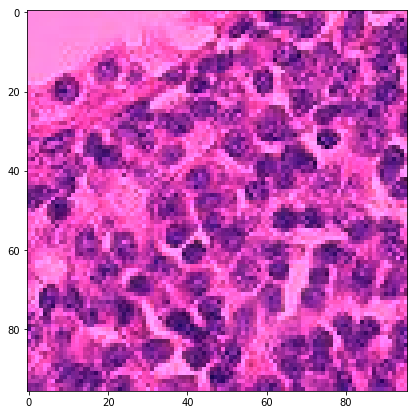

In [9]:

# This is where things go wrong. I am thinking that there is an error during rescaling
print(np.where(batches[3] > 1.1))
print("The wrong batch with strange values is:", batches[3][0])
print("The right image with good values in between 0 and 1 is",batches[2][0])

plt.imshow(batches[3])